# Standardalone driver of LIM

## Import modules

In [1]:
import math
import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# %matplotlib inline
mpl.rc('image', cmap='jet')

from read_AM_mod import JRA55, CMIP6, ERA5, NAM, SAM
from tools_AM_mod import cov_lag, find_event
from lim_mod_pt import LIM, rand_model

import torch
from torch import linalg as la
gpu = 0
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

with open("model_list.txt", "r") as f:
    model_list = f.readlines()
    model_list = [d.replace("\n", "") for d in model_list]
# model_list.remove("CESM2")

plev = [1000.,  850.,  700.,  500.,  250.,  100.,   50.,   10.]


## Load data

In [2]:
def get_y(data, index_name):
    D = NAM(data, index_name=index_name, annual_cycle_fft=2, running_mean=0, save_index=False)
    p = D.data.level
    print(D.data.name)

    y = D.cal_slice(month_start=11, len_slice=150)
    y = torch.from_numpy(y.astype('float32'))
    t = torch.arange(y.shape[1], dtype=y.dtype)

    y2 = D.cal_slice(month_start=11, len_slice=150, slice_offset=40)
    y2 = torch.from_numpy(y2.astype('float32'))

    print(f't.shape = {t.shape}, y.shape = {y.shape}, y2.shape = {y2.shape}')

    return D, p, y, t, y2

# data = JRA55(name_dir='jra_55', year_start=1958, year_end=2014, plev=plev, name='JRA55')
# 
data = ERA5(name_dir='ERA5', year_start=1950, year_end=2014, plev=plev, source_dir='cmip6')
data_z37 = ERA5(name_dir='ERA5', year_start=1950, year_end=2014, source_dir='cmip6')
data_y14 = ERA5(name_dir='ERA5', year_start=2014, year_end=2021, plev=plev, source_dir='cmip6')

D, p, y, t, y2 = get_y(data, 'NAM')
D_z37, p_z37, y_z37, t_z37, y2_z37 = get_y(data_z37, 'NAM_Z37')
D_y14, p_y14, y_y14, t_y14, y2_y14 = get_y(data_y14, 'NAM_2014-21')


Calculating from the original data .......
ERA5
t.shape = torch.Size([150]), y.shape = torch.Size([64, 150, 8]), y2.shape = torch.Size([64, 190, 8])
Calculating from the original data .......
ERA5
t.shape = torch.Size([150]), y.shape = torch.Size([64, 150, 37]), y2.shape = torch.Size([64, 190, 37])
Calculating from the original data .......
ERA5
t.shape = torch.Size([150]), y.shape = torch.Size([7, 150, 8]), y2.shape = torch.Size([7, 190, 8])


## Sensitivity to SVD truncation

In [3]:
def skills(model):
    lag = hyp_param['lim']['lag_time']
    ord = hyp_param['lim']['ord']

    Gt = (model.vr @ torch.diag(torch.exp(model.b * lag)) @ model.vl.conj().T).real
    Gt_norm = la.vector_norm(Gt, ord=ord)**ord

    LIM_err, LIM_R2 = model.LIM_skills(range(lag+1))
    err, R2 = LIM_err[-1], LIM_R2[-1]

    return Gt_norm, err, R2

def skills_r(y, r_min, r_max):
    norm_r = torch.empty((r_max-r_min+1, ))
    err_r = torch.empty_like(norm_r)
    R2_r = torch.empty_like(norm_r)
    for rr in range(r_min, r_max+1):
        hyp_param['lim']['r_optimal'] = rr
        model_r = LIM(y, hyp_param, verbose=False)
        norm_r[rr-r_min], err_r[rr-r_min], R2_r[rr-r_min] = skills(model_r)

    return norm_r, err_r, R2_r

hyp_param = dict(lim = dict(lag_time = 5,
                            r_optimal = None,
                            eig_method = 'pinv',
                            alpha = 1e-3,
                            ord   = 1,
                            )
                )

In [4]:
alpha = hyp_param['lim']['alpha']

lag = 5
r_r = range(2, 9)
norm_r, err_r, R2_r = skills_r(y, r_min=2, r_max=8)
loss_r = err_r + norm_r*alpha
r_opt_r = torch.argmin(loss_r).item() + 2

r_z37 = range(2, 18)
norm_z37, err_z37, R2_z37 = skills_r(y_z37, r_min=2, r_max=17)
loss_z37 = err_z37 + norm_z37*alpha
r_opt_z37 = torch.argmin(loss_z37).item() + 2

lag = 7
hyp_param['lim']['lag_time'] = 7
r_r = range(2, 9)
norm_lag7_r, err_lag7_r, R2_lag7_r = skills_r(y, r_min=2, r_max=8)
loss_lag7_r = err_lag7_r + norm_lag7_r*alpha
r_opt_lag7_r = torch.argmin(loss_lag7_r).item() + 2

r_z37 = range(2, 18)
norm_lag7_z37, err_lag7_z37, R2_lag7_z37 = skills_r(y_z37, r_min=2, r_max=17)
loss_lag7_z37 = err_lag7_z37 + norm_lag7_z37*alpha
r_opt_lag7_z37 = torch.argmin(loss_lag7_z37).item() + 2

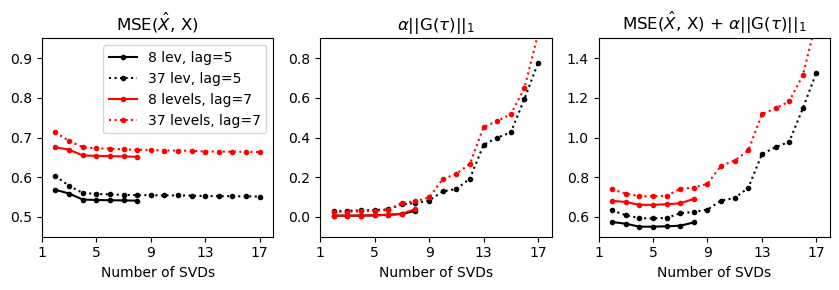

In [5]:
fig = plt.figure(figsize=(8.5,3))
fig.add_subplot(1,3,1)
plt.plot(r_r, err_r, 'k.-', label='8 lev, lag=5')
plt.plot(r_z37, err_z37, 'k.:', label='37 lev, lag=5')
plt.plot(r_r, err_lag7_r, 'r.-', label='8 levels, lag=7')
plt.plot(r_z37, err_lag7_z37, 'r.:', label='37 levels, lag=7')
plt.xticks(range(1, 18, 4))
plt.xlim((1, 18))
plt.xlabel('Number of SVDs')
plt.ylim((0.45, 0.95))
plt.title(r'MSE($\hat{X}$, X)')
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.legend()

fig.add_subplot(1,3,2)
plt.plot(r_r, norm_r*alpha, 'k.-')
plt.plot(r_z37, norm_z37*alpha, 'k.:')
plt.plot(r_r, norm_lag7_r*alpha, 'r.-')
plt.plot(r_z37, norm_lag7_z37*alpha, 'r.:')
plt.xticks(range(1, 18, 4))
plt.xlim((1, 18))
plt.xlabel('Number of SVDs')
plt.ylim((-0.1, 0.9))
plt.title(r'$\alpha$||G($\tau$)||$_1$')
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
# plt.legend()

fig.add_subplot(1,3,3)
plt.plot(r_r, loss_r, 'k.-')
plt.plot(r_z37, loss_z37, 'k.:')
plt.plot(r_r, loss_lag7_r, 'r.-')
plt.plot(r_z37, loss_lag7_z37, 'r.:')
plt.xticks(range(1, 18, 4))
plt.xlim((1, 18))
plt.xlabel('Number of SVDs')
plt.ylim((0.5, 1.5))
plt.title(r'MSE($\hat{X}$, X) + $\alpha$||G($\tau$)||$_1$')
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
# plt.legend()

plt.tight_layout()
# plt.savefig(f'Figs/LIM_L1_norm.pdf', transparent=True)

## Tau test and error growth

In [6]:
hyp_param = dict(lim = dict(lag_time = 5,
                            r_optimal = None,
                            eig_method = 'pinv',
                            alpha = 1e-3,
                            ord   = 1,
                            )
                )
print(f'hyperpamameters:\n{hyp_param}')

model = LIM(y, hyp_param, verbose=False)
y3 = rand_model(model.B, model.vr_Q, model.w_Q, len_t=150000, verbose=False)
model3 = LIM(y3[None, :], hyp_param, verbose=False)

model_z37 = LIM(y_z37, hyp_param, verbose=False)
y3_z37 = rand_model(model_z37.B, model_z37.vr_Q, model_z37.w_Q, len_t=150000, verbose=False)
model3_z37 = LIM(y3_z37[None, :], hyp_param, verbose=False)

hyperpamameters:
{'lim': {'lag_time': 5, 'r_optimal': None, 'eig_method': 'pinv', 'alpha': 0.001, 'ord': 1}}


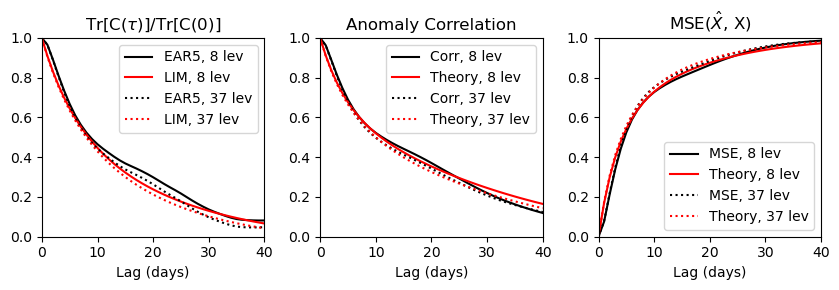

In [7]:
lag_time = 40
lags = torch.arange(lag_time+1)

# Z8
C0 = cov_lag(y, lag_time=0)
Ct_trace = np.array([np.trace(cov_lag(y, lag)) for lag in lags])
Ctf_trace = np.trace(np.squeeze(model.forecast(C0, lags)), axis1=1, axis2=2)

y_err, y_R2 = model.forecast_offset(y2, lags, D.slice_offset)
LIM_err, LIM_R2 = model.LIM_skills(lags)

# Z37
C0_z37 = cov_lag(y_z37, lag_time=0)
Ct_z37_trace = np.array([np.trace(cov_lag(y_z37, lag)) for lag in lags])
Ctf_z37_trace = np.trace(np.squeeze(model_z37.forecast(C0_z37, lags)), axis1=1, axis2=2)

y_z37_err, y_z37_R2 = model_z37.forecast_offset(y2_z37, lags, D_z37.slice_offset)
LIM_z37_err, LIM_z37_R2 = model_z37.LIM_skills(lags)

fig = plt.figure(figsize=(8.5,3))
fig.add_subplot(1, 3, 1)
plt.plot(lags, Ct_trace/np.trace(C0), 'k-', label='EAR5, 8 lev')
plt.plot(lags, Ctf_trace/np.trace(C0), 'r-', label='LIM, 8 lev')
plt.plot(lags, Ct_z37_trace/np.trace(C0_z37), 'k:', label='EAR5, 37 lev')
plt.plot(lags, Ctf_z37_trace/np.trace(C0_z37), 'r:', label='LIM, 37 lev')
plt.xlabel('Lag (days)')
plt.xlim((0, lag_time))
plt.ylim((0, 1.0))
plt.title(r'Tr[C($\tau$)]/Tr[C(0)]')
plt.legend()

fig.add_subplot(1, 3, 2)
plt.plot(lags, y_R2**0.5, 'k-', label=r'Corr, 8 lev')
plt.plot(lags, LIM_R2**0.5, 'r-', label='Theory, 8 lev')
plt.plot(lags, y_z37_R2**0.5, 'k:', label=r'Corr, 37 lev')
plt.plot(lags, LIM_z37_R2**0.5, 'r:', label=r'Theory, 37 lev')
plt.xlabel('Lag (days)')
plt.xlim((0, lag_time))
plt.ylim((0, 1.0))
plt.title(r'Anomaly Correlation')
plt.legend()

fig.add_subplot(1, 3, 3)
plt.plot(lags, y_err, 'k-', label=r'MSE, 8 lev')
plt.plot(lags, LIM_err, 'r-', label='Theory, 8 lev')
plt.plot(lags, y_z37_err, 'k:', label=r'MSE, 37 lev')
plt.plot(lags, LIM_z37_err, 'r:', label=r'Theory, 37 lev')
plt.xlabel('Lag (days)')
plt.xlim((0, lag_time))
plt.ylim((0, 1.0))
plt.title(r'MSE($\hat{X}$, X)')
plt.legend()

plt.tight_layout()
# plt.savefig('Figs/LIM_skills.pdf', transparent=True)

## Eigenvalues and eigenvectors

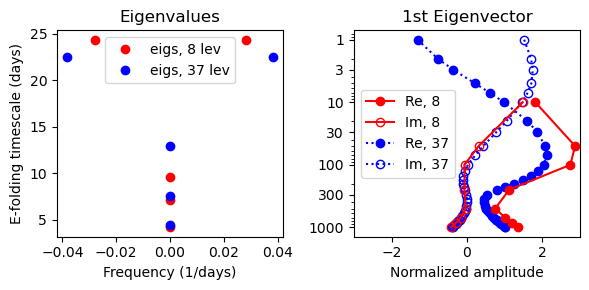

In [8]:
fig = plt.figure(figsize=(6,3))
fig.add_subplot(1,2,1)
plt.plot(model.b.imag, -1/model.b.real,  'or', label='eigs, 8 lev')
plt.plot(model_z37.b.imag, -1/model_z37.b.real,  'ob', label='eigs, 37 lev')
plt.xlabel('Frequency (1/days)')
plt.ylabel('E-folding timescale (days)')
plt.title('Eigenvalues')
plt.legend()

fig.add_subplot(1,2,2)
k10 = np.isin(p, 10).nonzero()[0][0]
sn = np.sign(model.vr[k10, 0].real)*model.vr[:, 0].std()
k10_z37 = np.isin(p_z37, 10).nonzero()[0][0]
sn_z37 = np.sign(model_z37.vr[k10_z37, 0].real)*model_z37.vr[:, 0].std()
plt.plot(model.vr[:, 0].real/sn, p, 'o-r', zorder=3, label='Re, 8')
plt.plot(model.vr[:, 0].imag/sn, p, 'o-r', mfc='none', zorder=4, label='Im, 8')
plt.plot(model_z37.vr[:, 0].real/sn_z37, p_z37, 'o:b', label='Re, 37')
plt.plot(model_z37.vr[:, 0].imag/sn_z37, p_z37, 'o:b', mfc='none', label='Im, 37')
plt.gca().invert_yaxis()
plt.xlabel('Normalized amplitude')
# plt.ylabel('Pressure (hPa)')
plt.xlim((-3, 3))
plt.yscale('log')
plt.yticks([1, 3, 10, 30, 100, 300, 1000])
plt.title('1st Eigenvector')
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.legend()

plt.tight_layout()
# plt.savefig('Figs/LIM_eigs.pdf', transparent=True)

## Lagged regression

In [9]:
def cal_Ct_p(y, p, p_level):
    k = np.isin(p, p_level)
    Ct_p = np.array([cov_lag(y[:, :, :].numpy(), lag, -y[:, :, k].numpy()) for lag in lags])
    Ct_p_lag = np.array([cov_lag(-y[:, :, k].numpy(), lag, y[:, :, :].numpy()) for lag in lags])
    return Ct_p, Ct_p_lag

lag_time = 40
lags = range(lag_time+1)
lags2= range(-lag_time, lag_time+1)
Ct_p0, Ct_p0_lag = cal_Ct_p(y, p, p_level=10)
Ct_p3, Ct_p3_lag = cal_Ct_p(y3[None, :], p, p_level=10)

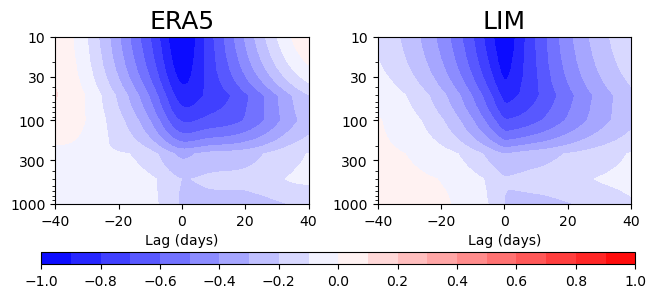

In [10]:
def plot_lag_reg(name, p, Ct_p0, Ct_p0_lag):
    plt.contourf(lags2, p, np.vstack((np.flipud(Ct_p0_lag[1:,:]), Ct_p0)).T, np.linspace(-cmax, cmax, cnum*2-1), cmap=cm)
    # plt.plot(np.zeros_like(p), p, '-k')
    plt.gca().invert_yaxis()
    plt.yscale('log')
    plt.yticks([10, 30, 100, 300, 1000])
    # plt.ylabel('hPa')
    plt.xticks([-40, -20, 0, 20, 40])
    plt.xlabel('Lag (days)')
    plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.title(name, fontsize=18)

cm = 'bwr' # 'seismic' # 'RdBu_r'
fig = plt.figure(figsize=(6.6,3))
mpl.rcParams.update({'font.size': 10})

cmax, cnum = 1, 11
ax1 = fig.add_subplot(1, 2, 1)
plot_lag_reg('ERA5', p, Ct_p0, Ct_p0_lag)
ax1 = fig.add_subplot(1, 2, 2)
plot_lag_reg('LIM', p, Ct_p3, Ct_p3_lag)

plt.tight_layout()
fig.subplots_adjust(bottom=0.3)
cax = fig.add_axes([0.07, 0.1, 0.90, 0.04])    #[left, bottom, width, height]
cbar = plt.colorbar(cax=cax, orientation='horizontal')
cbar.set_ticks(np.linspace(-cmax, cmax, cnum))

# plt.savefig('Figs/AM_reg_ERA5_LIM.pdf', transparent=True)

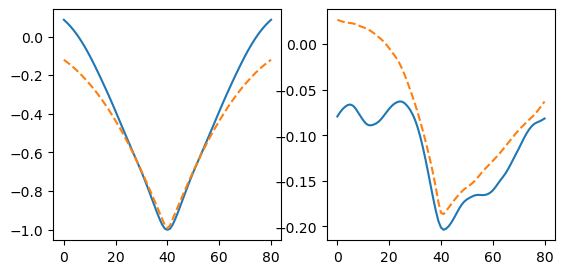

In [11]:
fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(1, 3, 1)
plt.plot(np.vstack((np.flipud(Ct_p0_lag[1:,:]), Ct_p0))[:, 0])
plt.plot(np.vstack((np.flipud(Ct_p3_lag[1:,:]), Ct_p3))[:, 0], '--')

ax1 = fig.add_subplot(1, 3, 2)
plt.plot(np.vstack((np.flipud(Ct_p0_lag[1:,:]), Ct_p0))[:, 4])
plt.plot(np.vstack((np.flipud(Ct_p3_lag[1:,:]), Ct_p3))[:, 4], '--')


## Weak vortex events

In [12]:
lag_time = 40
threshold = -2
lags = np.arange(lag_time+1)
lags2= range(-lag_time, lag_time+1)
y0_neg_event, y0_num = find_event(y.numpy(), p, y2=y2.numpy(), threshold=threshold, lag_time=lag_time)
y3_neg_event, y3_num = find_event(y3[None, lag_time:].numpy(), p, y2=y3.numpy()[None,:], threshold=threshold, lag_time=lag_time)

# of events: 29(0.45)
# of events: 379(379.00)


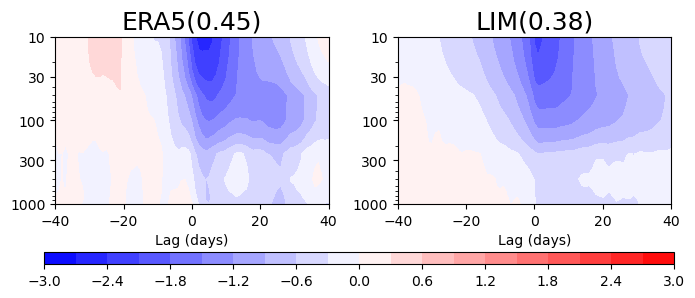

In [15]:
def plot_event(name, p, y0_neg_event, y0_num):
    plt.contourf(lags2, p, y0_neg_event.T, np.linspace(-cmax, cmax, cnum*2-1), cmap=cm)
    # plt.plot(np.zeros_like(p), p, '-k')
    plt.gca().invert_yaxis()
    plt.yscale('log')
    plt.yticks([10, 30, 100, 300, 1000])
    # plt.ylabel('hPa')
    plt.xticks([-40, -20, 0, 20, 40])
    plt.xlabel('Lag (days)')
    plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.title(f"{name}({y0_num:.2f})", fontsize=18)

cm = 'bwr' # 'RdBu_r' # 'seismic' # 
fig = plt.figure(figsize=(7,3))
mpl.rcParams.update({'font.size': 10})

cmax, cnum = 3, 11
ax1 = fig.add_subplot(1, 2, 1)
plot_event('ERA5', p, y0_neg_event, y0_num/(2014-1950))
ax1 = fig.add_subplot(1, 2, 2)
plot_event('LIM', p, y3_neg_event, y3_num/1000)

plt.tight_layout()
fig.subplots_adjust(bottom=0.3)
cax = fig.add_axes([0.07, 0.1, 0.90, 0.04])    #[left, bottom, width, height]
cbar = plt.colorbar(cax=cax, orientation='horizontal')
cbar.set_ticks(np.linspace(-cmax, cmax, cnum))
# mpl.rcParams.update({'font.size': 18})

# plt.savefig('Figs/AM_event_ERA5_LIM.pdf', transparent=True)

In [ ]:
fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(1, 3, 1)
plt.plot(y0_neg_event[:, 0])
plt.plot(y3_neg_event[:, 0], '--')

ax1 = fig.add_subplot(1, 3, 2)
plt.plot(y0_neg_event[:, 4])
plt.plot(y3_neg_event[:, 4], '--')


In [ ]:
fig = plt.figure(figsize=(3.3,3))
bin_e = np.linspace(-4, 4, 21)
bin_c = 0.5 * (bin_e[:-1] + bin_e[1:])

his_c, _ = np.histogram(y[:, :, 0].flatten(), bins=bin_e, density=True)
his3_c, _ = np.histogram(y3[:, 0], bins=bin_e, density=True)

plt.plot(bin_c, his_c, '-k')
plt.plot(bin_c, his3_c, '-b')
